## Цель вычислительного эксперимента 

Выбор алгоритма оптимизации на выборке: синтетической и MNIST с использованием моделей нейронных сетей простой структуры.

Предлагаемые алгоритмы оптимизации: SGD, Nesterov Momentum, Adam.

Структурные параметры: структура сети.

Критерии качества: скорость сходимости, значения оптимума, вид траектории.

## Описание выборок

База данных MNIST содержит 60000 изображений для обучения и 10000 изображений для тестирования. Половина образцов для обучения и тестирования были взяты из набора NIST для обучения, а другая половина — из набора NIST для тестирования. Образцы из набора NIST были нормализированы, прошли сглаживание и приведены к серому полутоновому изображению размером 28x28 пикселей.



In [1]:
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
%matplotlib inline

## Блок загрузки и предобработки выборок

Загружаем mnist из keras.datasets

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Преобразование размерности данных для входа модели

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

Нормализация данных

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

One-hot encoding целевых классов

In [6]:
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

## Анализ состава выборки

Распределение чисел в обучающей выборке: равномерное распределение по классам, выбросов нет

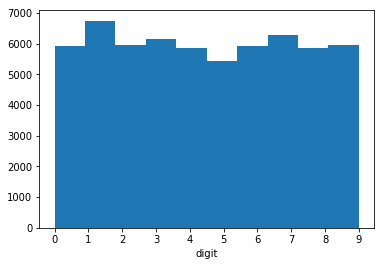

In [7]:
plt.hist(y_train, bins=10)
plt.xlabel("digit")
plt.xticks(range(10))
plt.show()

Пропусков в данных нет

In [8]:
np.isnan(X_train).any()

False

Матрица корреляции

/Users/dima/Desktop/Настя/nastya/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/dima/Desktop/Настя/nastya/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


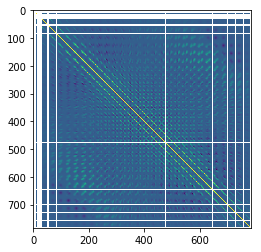

In [9]:
plt.imshow(np.corrcoef(X_train, rowvar=False))

## Модель: нейронная сеть простой структуры

In [10]:
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model

## Функция ошибки: кросс-энтропия

## Критерии качества: 
1. скорость сходимости
2. значения оптимума
3. вид траектории

## Способ разбиения выборки на обучение-контроль: MNIST изначально разбит на train и test, было взято данное разбиение

## Обучение моделей с разными алгоритмами оптимизации

In [11]:
optimizers = ['adam', 'SGD', 'nadam']
test_accuracy, history = dict(), dict()

for optimizer in tqdm(optimizers):
    model = create_model(optimizer)
    history[optimizer] = model.fit(
        X_train, Y_train, batch_size=128, epochs=10, 
        verbose=0, validation_data=(X_test, Y_test)
    )
    scores = model.evaluate(X_test, Y_test, verbose=0)
    test_accuracy[optimizer] = scores[1]

100%|██████████| 3/3 [02:12<00:00, 45.17s/it]


In [12]:
print(f"Качество на валидации: {test_accuracy}")

Качество на валидации: {'adam': 0.9827, 'SGD': 0.9397, 'nadam': 0.981}


In [13]:
def plot_metrics(history, optimizer='adam'):
    fig = plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    train_acc, test_acc = np.array(history.history['acc']), np.array(history.history['val_acc'])
    std_train_acc, std_test_acc = train_acc.std(), test_acc.std()
    
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.fill_between(np.arange(train_acc.shape[0]), train_acc+std_train_acc, train_acc-std_train_acc, alpha=0.5)
    plt.fill_between(np.arange(test_acc.shape[0]), test_acc+std_test_acc, test_acc-std_test_acc, alpha=0.5)
    
    
    plt.title(f'{optimizer}\n\nmodel accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.xticks(range(10))
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(2,1,2)
    train_loss, test_loss = np.array(history.history['loss']), np.array(history.history['val_loss'])
    std_train_loss, std_test_loss = train_loss.std(), test_loss.std()

    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.fill_between(np.arange(train_loss.shape[0]), train_loss+std_train_loss, train_loss-std_train_loss, alpha=0.5)
    plt.fill_between(np.arange(test_loss.shape[0]), test_loss+std_test_loss, test_loss-std_test_loss, alpha=0.5)
    
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xticks(range(10))
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.tight_layout()

## График скорости сходимости функции ошибки

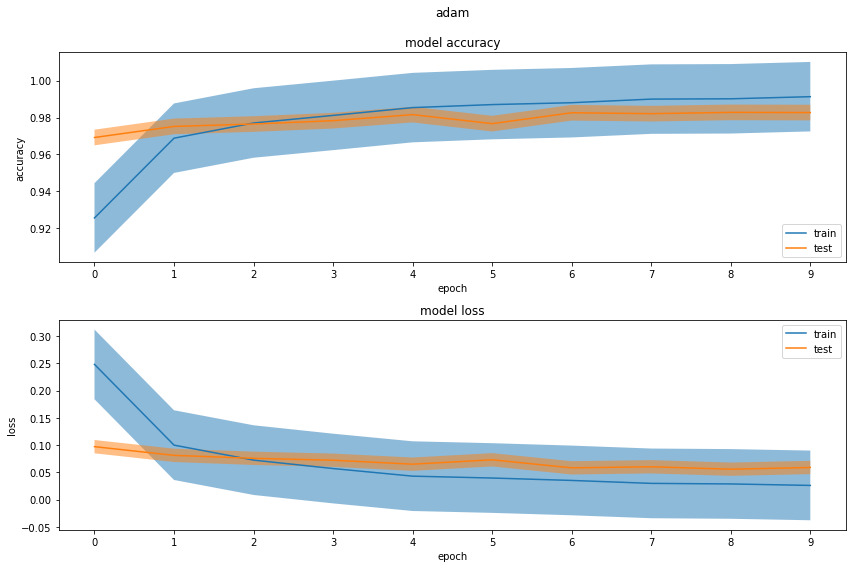

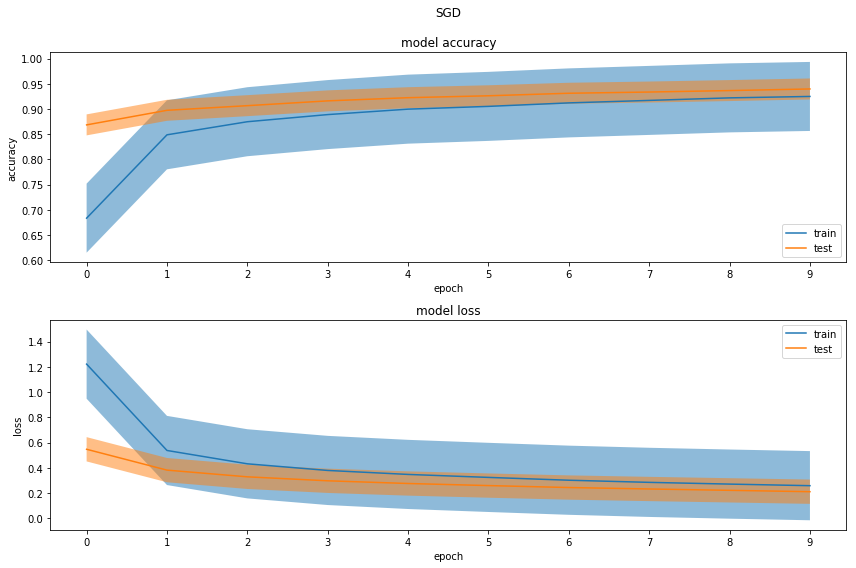

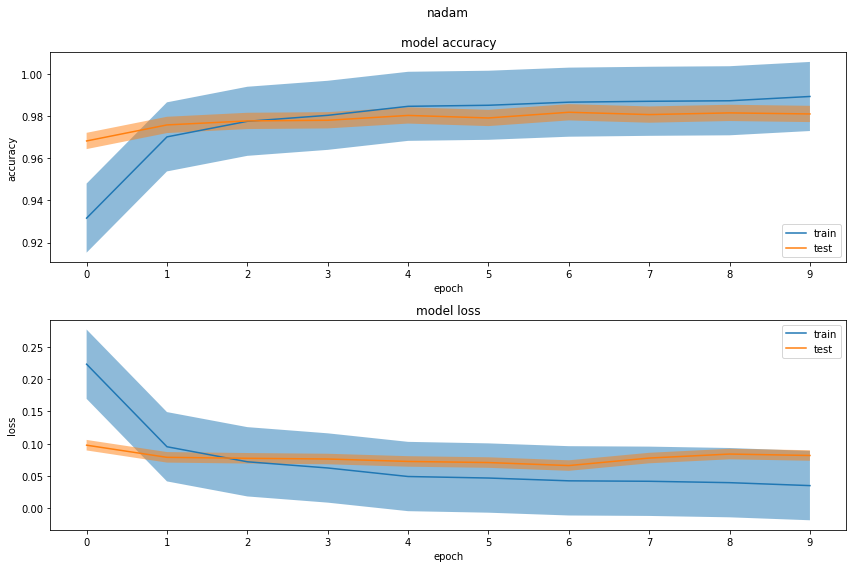

In [14]:
for optimizer in optimizers:
    plot_metrics(history[optimizer], optimizer)

### Лучшие результаты по скорости сходимости и качеству на отложенной выборке показала модель с алгоритом оптимизации ADAM.

## График зависимости функции ошибки от значения структурного параметра

В качестве структурного параметра возьмем количество нейронов в скрытом слое. Переберем степени двойки в качетсве числа нейронов: [16, 32, 64, 128, 256, 512]

In [15]:
def create_model(optimizer='adam', num_units=512):
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))

    model.add(Dense(num_units))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model

In [16]:
optimizers = ['adam', 'SGD', 'nadam']
test_accuracy, history = dict(), dict()
n_units = [16, 32, 64, 128, 256, 512]

for optimizer in tqdm(optimizers):
    history[optimizer], test_accuracy[optimizer] = [], []
    for num_units in n_units:
        model = create_model(optimizer, num_units)
        history[optimizer].append(model.fit(
            X_train, Y_train, batch_size=128, epochs=10, 
            verbose=0, validation_data=(X_test, Y_test)
        ))
        scores = model.evaluate(X_test, Y_test, verbose=0)
        test_accuracy[optimizer].append(scores[1])

100%|██████████| 3/3 [10:34<00:00, 214.87s/it]


В итоге получаем следующую зависимость значений точности и функции ошибки на отложенной выборке

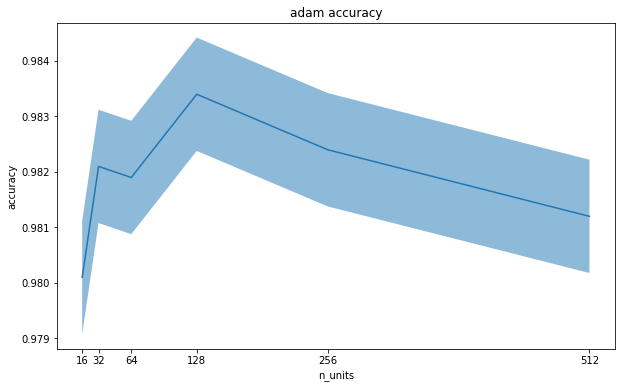

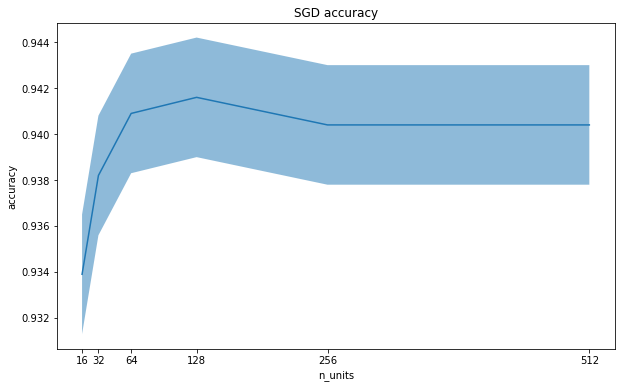

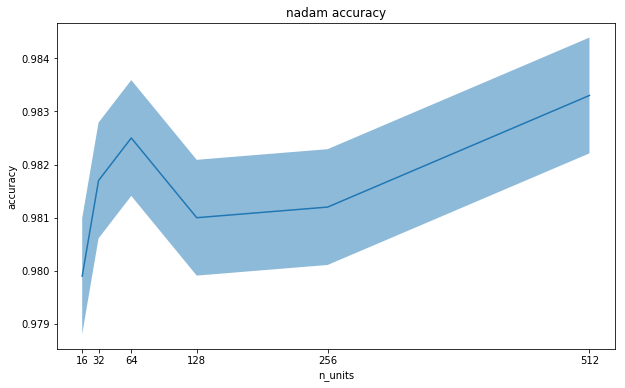

In [20]:
def plot_metric_for_n_units(test_accuracy, optimizer='adam'):
    fig = plt.figure(figsize=(10,6))
    acc = np.array(test_accuracy[optimizer])
    std_acc = acc.std()
    plt.plot(n_units, acc)
    plt.fill_between(n_units, acc+std_acc,
                     acc-std_acc, alpha=0.5)
    plt.title(f'{optimizer} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('n_units')
    plt.xticks(n_units)
    plt.show()
    
for optimizer in optimizers:
    plot_metric_for_n_units(test_accuracy, optimizer)

Как видно из графиков, количество нейронов в скрытом слое сильно и по-разному влияет на итоговые метрики модели на отложенной выборке.

Лучшее качество показала модель с алгоритмом оптимизации Nesterov Momentum, но как видно из графиков, ст. отклонение довольно большое для сравнения алгоритмов оптимизации Nesterov Momentum и Adam.

## Вывод
В качестве эксперимента решалась задача классификации датасета MNIST нейронной сетью простой структуры, содержащей 3 полносвязных слоя (2 функции активации RELU и SOFTMAX) с дропаутом. В качестве структурного параметра было выбрано число нейронов в скрытом слое сети. Инициализация весов производилась при помощи непрерывного распределения Хавьера

Лучшие метрики на при заданной структуре модели и при оптимальном значении структурного параметра имеет модель с алгоритмом оптимизации Nesterov Momentum.
SGD показывает значительно худшие результаты, а результаты Adam совсем чуть-чуть отличаюся от Nesterov Momentum.